<a href="https://colab.research.google.com/github/mamunm/iamge_caption_generator/blob/main/notebooks/Attention_Models_COCO_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pickle5

     |████████████████████████████████| 133kB 2.9MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219254 sha256=ee7455d8133f4f0cfff1c32e67026c87bc59bb611227a908ee51aa159a5206c6
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


In [ ]:
!pip install nltk

In [ ]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from glob import glob
import numpy as np 
import pandas as pd

from PIL import Image
import pickle5 as pickle
import time

from nltk.translate.bleu_score import corpus_bleu
import re

In [ ]:
# Model settings
NAME = 'COCO' # Flicker30k
IMAGE_MODEL = 'vgg16'
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
top_k = 10000
vocab_size = top_k + 1
num_steps = 400 if NAME == 'COCO' else 160 
features_shape = 512 if IMAGE_MODEL == 'vgg16' else 2048 #2048 for inception_v3
attention_features_shape = 81 if IMAGE_MODEL == 'vgg16' else 64 #64 for inception_v3
max_length = 45 if NAME == 'COCO' else 75

In [ ]:
# Load the numpy files
def load_data(batch, data='COCO', im_model='vgg16'):
    if data == 'COCO':
        root = '/content/drive/MyDrive/image_captioning_data/COCO/train_vectors/'
    else:
        root = '/content/drive/MyDrive/image_captioning_data/Flicker30k/train_vectors/'
    query = root + '*_{}_*_X_y_{:04d}_*'.format(im_model, batch)
    f_path = glob(query)
    data = np.load(f_path[0], allow_pickle=True)[()]
    return data['X'].numpy(), data['y']

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
      super(BahdanauAttention, self).__init__()
      self.W1 = tf.keras.layers.Dense(units)
      self.W2 = tf.keras.layers.Dense(units)
      self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
      hidden_with_time_axis = tf.expand_dims(hidden, 1)
      attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))
      score = self.V(attention_hidden_layer)
      attention_weights = tf.nn.softmax(score, axis=1)
      context_vector = attention_weights * features
      context_vector = tf.reduce_sum(context_vector, axis=1)
      return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)
    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)
        return x, state, attention_weights
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = f"/content/drive/MyDrive/image_captioning_data/{NAME}/Checkpoints/{NAME + '_' + IMAGE_MODEL}"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=30)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
with open(f'/content/drive/MyDrive/image_captioning_data/{NAME}/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss, total_loss

In [ ]:
loss_plot = []
EPOCHS = 20
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    for batch in range(1, num_steps+1):
        img_tensor, target = load_data(batch, data=NAME, im_model=IMAGE_MODEL)
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 100 Loss 2.3155
Epoch 1 Batch 200 Loss 2.4375
Epoch 1 Batch 300 Loss 1.7889
Epoch 1 Batch 400 Loss 2.6727
Epoch 1 Loss 2.621004
Time taken for 1 epoch 1305.10 sec

Epoch 2 Batch 100 Loss 1.7260
Epoch 2 Batch 200 Loss 1.9870
Epoch 2 Batch 300 Loss 1.5123
Epoch 2 Batch 400 Loss 2.2667
Epoch 2 Loss 2.070215
Time taken for 1 epoch 80.12 sec

Epoch 3 Batch 100 Loss 1.5558
Epoch 3 Batch 200 Loss 1.8007
Epoch 3 Batch 300 Loss 1.3687
Epoch 3 Batch 400 Loss 2.0588
Epoch 3 Loss 1.852341
Time taken for 1 epoch 80.18 sec

Epoch 4 Batch 100 Loss 1.4492
Epoch 4 Batch 200 Loss 1.6770
Epoch 4 Batch 300 Loss 1.2705
Epoch 4 Batch 400 Loss 1.9050
Epoch 4 Loss 1.707067
Time taken for 1 epoch 80.20 sec

Epoch 5 Batch 100 Loss 1.3495
Epoch 5 Batch 200 Loss 1.5733
Epoch 5 Batch 300 Loss 1.1949
Epoch 5 Batch 400 Loss 1.8026
Epoch 5 Loss 1.595059
Time taken for 1 epoch 80.00 sec

Epoch 6 Batch 100 Loss 1.2726
Epoch 6 Batch 200 Loss 1.4698
Epoch 6 Batch 300 Loss 1.1467
Epoch 6 Batch 400 Loss 1.709

In [ ]:
df_loss = pd.DataFrame({'loss': [i.numpy() for i in loss_plot], 'epoch': np.arange(1, 21)})

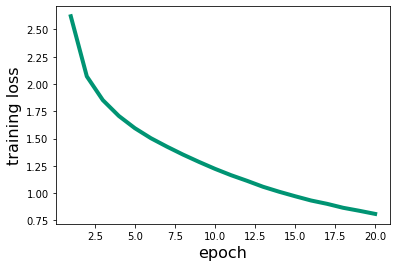

In [ ]:
sns.lineplot(data=df_loss, x='epoch', y='loss', color='#009473', linewidth=4)
plt.xlabel('epoch', fontsize=16)
plt.ylabel('training loss', fontsize=16)
plt.savefig(f'/content/drive/MyDrive/image_captioning_data/{NAME}/{NAME}_{IMAGE_MODEL}.png')

In [ ]:
def evaluate(img_tensor_val):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [ ]:
# captions on the validation set
#fpath = f'/content/drive/MyDrive/image_captioning_data/{NAME}/val_vectors/'
#query = fpath + '*_{}_*'.format(IMAGE_MODEL)
#fpath = glob(query)

#data = np.load(np.random.choice(fpath), allow_pickle=True)[()]
#rid = np.random.choice(90)
#X, y = data['X'].numpy()[rid], data['y'][rid]
reid = re.compile(r'\d{12}')
a = glob(f'/content/drive/MyDrive/image_captioning_data/{NAME}/val_vectors/val_{IMAGE_MODEL}*')
for aa in a:
    data = np.load(aa, allow_pickle=True)[()]
    X, y = data['X'].numpy()[0], data['y'][0]
    if NAME == 'COCO':
        iid = reid.findall(aa)[0]
        image_id = f'/content/drive/MyDrive/image_captioning_data/COCO/val_images/COCO_train2014_{iid}.jpg'
    else:
        iid = reid.findall(aa)[0].lstrip('0')
        image_id = f'/content/drive/MyDrive/image_captioning_data/Flicker30k/val_images/{iid}.jpg'

    real_caption = ' '.join([tokenizer.index_word[i]
                        for i in y if i not in [0]])
    result, attention_plot = evaluate(X)
    print(image_id)
    print('Real Caption:', real_caption)
    print('Prediction Caption:', ' '.join(result))
    plot_attention(image_id, result, attention_plot)

In [ ]:
val_data_files = glob(f'/content/drive/MyDrive/image_captioning_data/{NAME}/val_vectors/val_{IMAGE_MODEL}*')

real = []
prediction = []
for v in val_data_files:
    data = np.load(v, allow_pickle=True)[()]
    for x, y in zip(data['X'].numpy(), data['y']):
        real.append(' '.join([tokenizer.index_word[i]
                        for i in y if i not in [0]]))
        result, _ = evaluate(x)
        prediction.append(' '.join(result))


In [ ]:
def sub_tok(x):
    x = re.sub('<start>', '', x)
    x = re.sub('<end>', '', x)
    return x

In [ ]:
real = [sub_tok(i) for i in real]
prediction = [sub_tok(i) for i in real]


In [ ]:
np.save(f'/content/drive/MyDrive/image_captioning_data/{NAME}/{NAME}_{IMAGE_MODEL}_pred.npy', 
        {'real': real, 'pred': prediction})